# Training a Regressor

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.autograd import Variable
from statistics import mean
import matplotlib.pyplot as plt
import _pickle as cPickle
from tqdm import tqdm
from scipy.stats import spearmanr

In [2]:
train_save_path = "datasets/ME/out_features/train_features_VQA.pkl"

In [3]:
pooled_dict = cPickle.load(open(train_save_path, 'rb'))

In [4]:
pooled_output_mul = pooled_dict["pooled_output_mul"]
pooled_output_sum = pooled_dict["pooled_output_sum"]
pooled_output_t = pooled_dict["pooled_output_t"]
pooled_output_v = pooled_dict["pooled_output_v"]
concat_pooled_output = pooled_dict["concat_pooled_output"]
targets = pooled_dict["targets"]

In [5]:
indices = {
    "0": {},
    "1": {},
    "2": {},
    "3": {},
}

In [6]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=4)

for i, (train_index, test_index) in enumerate(kf.split(pooled_output_mul)):
    indices[str(i)]["train"] = train_index
    indices[str(i)]["test"] = test_index

In [10]:
class SigLinNet(nn.Module):
    def __init__(self, input_size, 
                 hidden_size_1,
                 hidden_size_2, 
                 hidden_size_3, 
                 num_scores):
        super(SigLinNet, self).__init__()
        self.out = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.Sigmoid(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.Sigmoid(),
            nn.Linear(hidden_size_2, hidden_size_3),
            nn.Sigmoid(),
            nn.Linear(hidden_size_3, num_scores),
        )

    def forward(self, x):
        return self.out(x)

In [12]:
def train_reg(inputs, targets, input_size, output_size, split, model, batch_size, epoch, lr, score, *argv):
    torch.manual_seed(42)
    nets = []
    los = []

    for i in range(len(split)):
        ind = list(split[str(i)]["train"])
        if score == "both":
            torch_dataset = Data.TensorDataset(inputs[ind], targets[ind])
        elif score == "stm":
            torch_dataset = Data.TensorDataset(inputs[ind], targets[ind,0].reshape(-1,1))
        elif score == "ltm":
            torch_dataset = Data.TensorDataset(inputs[ind], targets[ind,1].reshape(-1,1))

        loader = Data.DataLoader(
            dataset=torch_dataset, 
            batch_size=batch_size, 
            shuffle=True
        )

        net = model(input_size, *argv, output_size)
        net.cuda()

        optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)
        loss_func = torch.nn.MSELoss()

        losses = []
        net.train()
        for _ in tqdm(range(epoch), desc="Split %d" % i):
            errors = []
            for step, (batch_in, batch_out) in enumerate(loader):
                optimizer.zero_grad()

                b_in = Variable(batch_in)
                b_out = Variable(batch_out)

                prediction = net(b_in)

                loss = loss_func(prediction, b_out)
                errors.append(loss.item())

                loss.backward()
                optimizer.step()
            losses.append(mean(errors))
            #if not (epoch+1) % 10:
            #    print('Epoch {}: train loss: {}'.format(epoch+1, mean(errors))
        nets.append(net)
        los.append(losses)
    return nets, los

In [13]:
def test_reg(nets, inputs, targets, split, score):
    losses = list()
    rhos = {"stm": [], "ltm": []}
    
    loss_func = torch.nn.MSELoss()

    for i, net in enumerate(nets):
        ind = list(split[str(i)]["test"])
        if score == "both":
            torch_dataset_val = Data.TensorDataset(inputs[ind], targets[ind])
        elif score == "stm":
            torch_dataset_val = Data.TensorDataset(inputs[ind], targets[ind,0].reshape(-1,1))
        elif score == "ltm":
            torch_dataset_val = Data.TensorDataset(inputs[ind], targets[ind,1].reshape(-1,1))

        loader_val = Data.DataLoader(
            dataset=torch_dataset_val, 
            batch_size=VAL_BATCH_SIZE, 
            shuffle=False
        )

        dataiter_val = iter(loader_val)
        in_, out_ = dataiter_val.next()

        curr_net = net

        curr_net.eval()
        pred_scores = curr_net(in_)

        loss = loss_func(pred_scores, out_)
        losses.append(loss.item())

        r, _ = spearmanr(
            pred_scores.cpu().detach().numpy()[:,0], 
            out_.cpu().detach().numpy()[:,0], 
            axis=0
        )
        rhos["stm"].append(r)

        r, _ = spearmanr(
            pred_scores.cpu().detach().numpy()[:,1], 
            out_.cpu().detach().numpy()[:,1], 
            axis=0
        )
        rhos["ltm"].append(r)
    
    return rhos, losses

In [14]:
BATCH_SIZE = 128
VAL_BATCH_SIZE = 2000
EPOCH = 200
lr = 4e-4

## 1024-input train

In [15]:
nets, los = train_reg(
    pooled_output_sum, 
    targets, 
    1024, # input size
    2, # output size
    indices, # train and validation indices for each split
    SigLinNet, # model class to be used
    BATCH_SIZE, 
    EPOCH, 
    lr,
    "both", # predict both scores
    512, 64, 32 # sizes of hidden network layers
)

Split 3: 100%|██████████| 200/200 [00:23<00:00,  8.48it/s]


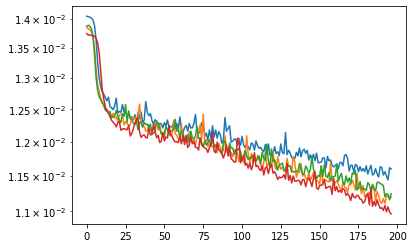

In [16]:
for l in los:
    plt.plot(l[3:])
plt.yscale('log')

## 1024-input test

In [17]:
rhos, losses = test_reg(nets, pooled_output_sum, targets, indices, "both")

In [18]:
rhos

{'stm': [0.4479491832417632,
  0.46421804783154824,
  0.4708940712987392,
  0.4659157970920723],
 'ltm': [0.2292920750051904,
  0.2452806470939227,
  0.22359975943219537,
  0.23097835805305242]}

In [19]:
mean(rhos["stm"]), mean(rhos["ltm"])

(0.46224427486603076, 0.2322877098960902)

## 2048-input train

In [73]:
nets_2, los_2 = train_reg(
    concat_pooled_output, 
    targets, 
    2048, 
    2, 
    indices, 
    SigLinNet, 
    BATCH_SIZE, 
    EPOCH, 
    lr,
    "both",
    512, 64, 32
)

Split 3: 100%|██████████| 200/200 [00:23<00:00,  8.52it/s]


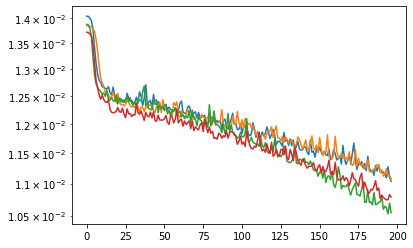

In [74]:
for l in los_2:
    plt.plot(l[3:])
plt.yscale('log')

## 2048-input test

In [76]:
rhos_2, losses_2 = test_reg(nets_2, concat_pooled_output, targets, indices, "both")

In [77]:
rhos_2

{'stm': [0.44047708554933207,
  0.4723136614637303,
  0.45800487540106927,
  0.47713459576054856],
 'ltm': [0.2098259251643052,
  0.23401166863995182,
  0.21126535858501036,
  0.2325589943398754]}

In [78]:
mean(rhos_2["stm"]), mean(rhos_2["ltm"])

(0.46198255454367004, 0.2219154866822857)